# AdhereR Data Sets
- `tidy_dataset.csv` corresponds to [AdhereR | med.events](https://rdrr.io/cran/AdhereR/man/med.events.html)
- `med_events_ATC.csv` corresponds to [AdhereR | med.events.ATC](https://search.r-project.org/CRAN/refmans/AdhereR/html/med.events.ATC.html)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
def compute_event_interval(df):
    """
    For each patient, compute the difference in days between consecutive medication events.
    This is our "event interval".
    """
    df = df.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    df['prev_DATE'] = df.groupby('PATIENT_ID')['DATE'].shift(1)
    # Remove rows without a previous event (first event for each patient)
    df = df.dropna(subset=['prev_DATE'])
    df['event_interval'] = (df['DATE'] - df['prev_DATE']).dt.days
    return df

def empirical_cdf(data):
    """
    Compute the empirical cumulative distribution function (ECDF) for a 1D array.
    Returns:
      x : Sorted event intervals (days) [dfper$x in R]
      y : Cumulative probability [dfper$y in R]
    """
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def optimal_kmeans_silhouette(X, k_min=2, k_max=10):
    """
    Determine the optimal number of clusters (k) by computing the silhouette score for each k,
    and plot the average silhouette width vs. k.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The data to cluster.
    k_min : int, optional (default=2)
        Minimum number of clusters to try.
    k_max : int, optional (default=10)
        Maximum number of clusters to try.

    Returns
    -------
    best_k : int
        The k that yields the highest average silhouette score.
    """
    k_values = range(k_min, k_max + 1)
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    best_k = k_values[np.argmax(silhouette_scores)]

    # Plot silhouette scores (points only)
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
    plt.axvline(x=best_k, color='blue', linestyle='--')
    plt.title('Optimal number of clusters\nSilhouette Analysis', fontsize=14)
    plt.xlabel('Number of clusters k', fontsize=12)
    plt.ylabel('Average silhouette width', fontsize=12)
    plt.xticks(list(k_values))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return best_k

def process_medications(atc_code):
    """
    Process medication events for a specific ATC code.
    
    Steps:
      1. Filter data for the chosen ATC code.
      2. Compute the event interval (days between consecutive events).
      3. Generate ECDF plots (100% and 80%) of the event interval.
      4. Subset data to the lower 80% of event intervals (to remove extreme values).
         If this subset is empty, use the full dataset.
      5. Plot the density of the log-transformed event interval (with N and bandwidth annotated).
      6. Determine the optimal number of clusters via silhouette analysis and perform clustering.
      7. Generate a box plot of event intervals by prescription order (p_number) with group medians annotated.
    """
    # 1. Filter dataset for the desired ATC code
    df_med = med_events_df[med_events_df['ATC'] == atc_code].copy()
    df_med = compute_event_interval(df_med)
    
    # 2. Compute the ECDF for the event_interval (100% ECDF)
    x_ecdf, y_ecdf = empirical_cdf(df_med['event_interval'])
    df_ecdf = pd.DataFrame({'event_interval': x_ecdf, 'cdf': y_ecdf})
    
    # 3. Retain only the lower 80% of the ECDF (i.e., where cdf <= 0.8)
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    ni = df_ecdf_80['event_interval'].max()
    
    print(f"ATC code {atc_code} - Total events: {len(df_ecdf)}, 80% events: {len(df_ecdf_80)}, ni: {ni}")
    
    # 4. Plot ECDFs for both 80% and 100% of the data
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Left: 80% ECDF
    axes[0].plot(df_ecdf_80['event_interval'], df_ecdf_80['cdf'], marker='o', linestyle='None')
    axes[0].set_title('80% ECDF of Event Intervals', fontsize=14)
    axes[0].set_xlabel('Event Interval in Days (dfper$x)', fontsize=12)
    axes[0].set_ylabel('Cumulative Probability (dfper$y)', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    # Right: 100% ECDF
    axes[1].plot(df_ecdf['event_interval'], df_ecdf['cdf'], marker='o', linestyle='None')
    axes[1].set_title('100% ECDF of Event Intervals', fontsize=14)
    axes[1].set_xlabel('Event Interval in Days (x)', fontsize=12)
    axes[1].set_ylabel('Cumulative Probability (y)', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 5. Subset data to lower 80% range; if empty, fallback to full dataset
    df_subset = df_med[df_med['event_interval'] <= ni].copy()
    if df_subset.empty:
        print("No data in the 80% range. Using full dataset for density and clustering.")
        df_subset = df_med.copy()
    
    # 6. Plot the density of the log-transformed event interval for the subset
    # Filter out non-positive values to avoid issues with log(0)
    positive_intervals = df_subset['event_interval'][df_subset['event_interval'] > 0]
    if len(positive_intervals) < 2:
        print("Not enough positive event intervals for density estimation. Skipping density plot.")
    else:
        log_intervals = np.log(positive_intervals)
        try:
            density = gaussian_kde(log_intervals)
        except Exception as e:
            print("Error computing density:", e)
        else:
            x_density = np.linspace(log_intervals.min(), log_intervals.max(), 200)
            y_density = density(x_density)
            # Compute bandwidth similar to R's default approach
            bandwidth = density.factor * log_intervals.std(ddof=1)
            n_points = len(log_intervals)
            
            plt.figure(figsize=(5, 8))
            plt.plot(x_density, y_density, color='blue')
            plt.title('Log(event interval)', fontsize=14)
            plt.xlabel('Log(Event Interval)', fontsize=12)
            plt.ylabel('Density', fontsize=12)
            # Place "N = xx   Bandwidth = xx" below the plot using figtext
            text_str = f'N = {n_points}   Bandwidth = {bandwidth:.4f}'
            plt.figtext(0.5, 0.01, text_str, ha='center', fontsize=12)
            plt.show()
    
    # 7. Clustering on the subset (using event_interval)
    scaler = StandardScaler()
    X = scaler.fit_transform(df_subset[['event_interval']])
    if len(X) < 2:
        print("Not enough data for clustering. Skipping clustering step.")
        cluster_summary = pd.DataFrame()
    else:
        optimal_k = optimal_kmeans_silhouette(X)
        print(f"Optimal number of clusters for ATC code {atc_code}: {optimal_k}")
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        df_subset['Cluster'] = kmeans.fit_predict(X)
        cluster_summary = df_subset.groupby('Cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
    
    # 8. Box plot by prescription order (p_number)
    # Compute prescription order (p_number) for each patient
    df_sorted = df_med.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    # Exclude the first event (p_number = 1) since it has no event interval
    df_filtered = df_sorted[df_sorted['p_number'] >= 2].copy()
    
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x='p_number', y='event_interval', data=df_filtered)
    plt.xticks(rotation=90)
    overall_median = df_filtered['event_interval'].median()
    plt.axhline(y=overall_median, color='red', linestyle='--', label='Overall Median')
    # Annotate each group's median
    medians = df_filtered.groupby('p_number')['event_interval'].median()
    for i, median_val in enumerate(medians):
        ax.text(i, median_val, f'{median_val:.1f}', horizontalalignment='center',
                verticalalignment='bottom', color='blue', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Boxplot of Duration (Event Interval) by PATIENT_ID (p_number)', fontsize=14)
    plt.xlabel('PATIENT_ID (p_number)', fontsize=12)
    plt.ylabel('Duration (days)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return df_med, cluster_summary

# med.events.ATC

This is a demo on the `med.events.ATC` dataset with smaller sample sizes due to the large quantity of `CATEGORY` possibilities.

So, in this example, we only opt for a single category (`J01FA10`) which has 112 total events (rows), for testing purposes.

Dataset columns: ['PATIENT_ID', 'DATE', 'DURATION', 'PERDAY', 'ATC', 'CATEGORY_L1', 'CATEGORY_L2']
ATC code J01FA10 - Total events: 112, 80% events: 89, ni: 42


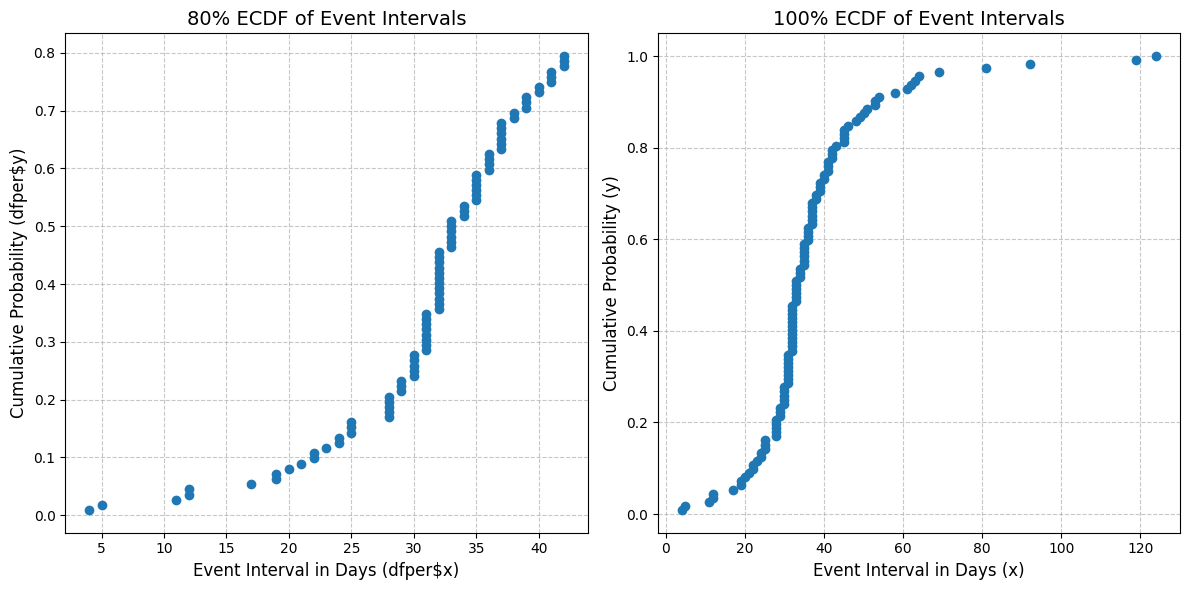

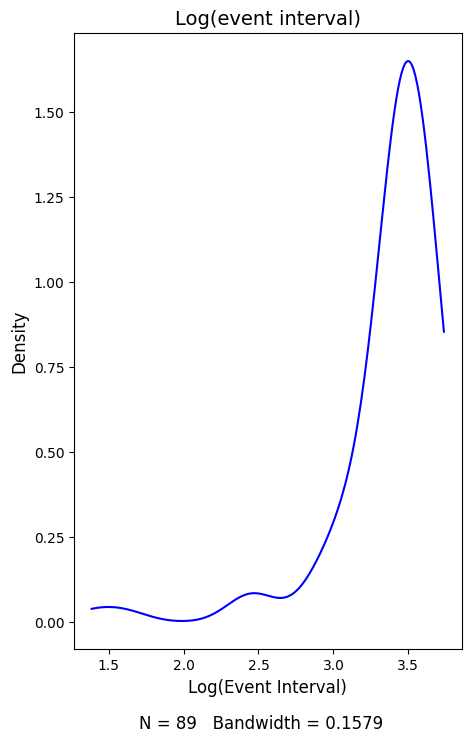

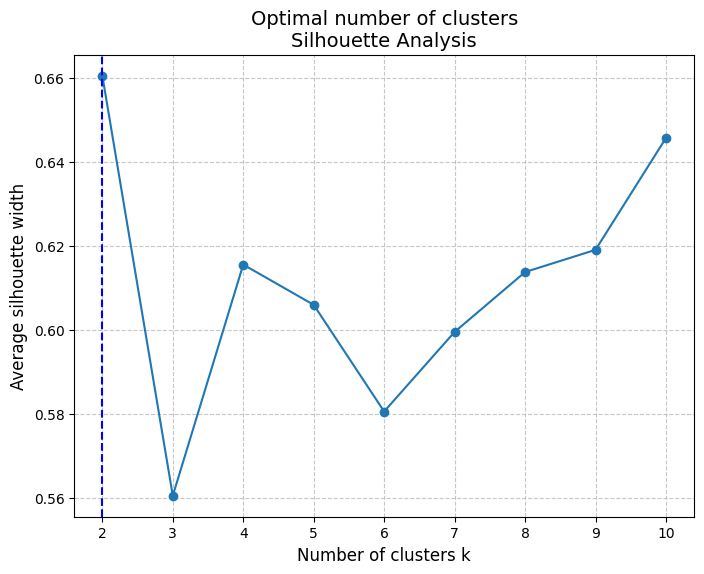

Optimal number of clusters for ATC code J01FA10: 2


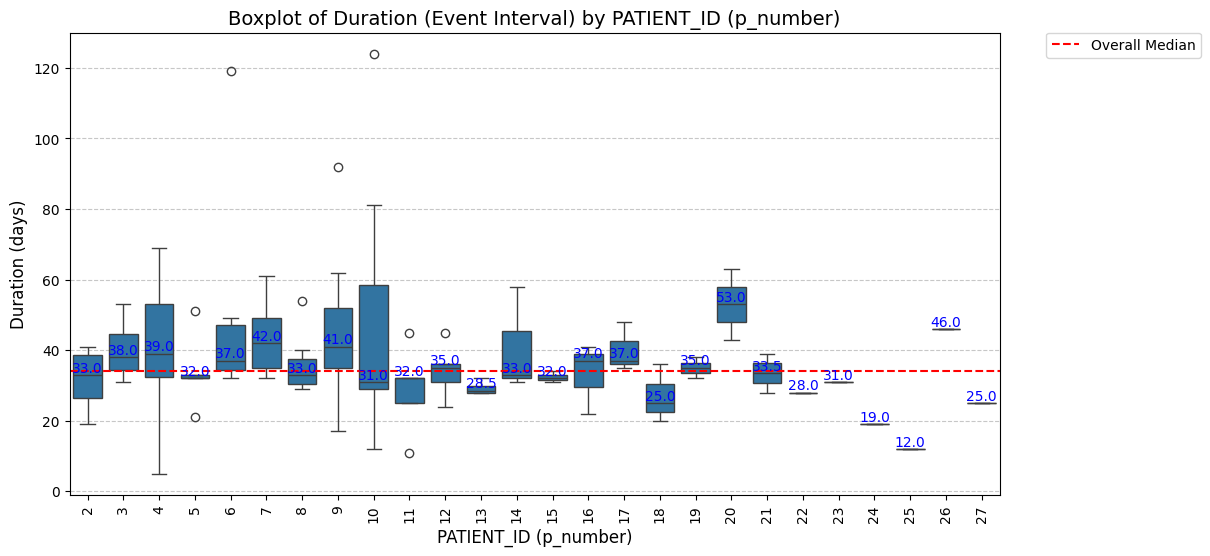

In [35]:
med_events_df = pd.read_csv('../data/med_events_ATC.csv', parse_dates=['DATE'])
# Rename the column "CATEGORY" to "ATC" so that our code can filter using 'ATC'
if 'CATEGORY' in med_events_df.columns:
    med_events_df.rename(columns={'CATEGORY': 'ATC'}, inplace=True)
print("Dataset columns:", med_events_df.columns.tolist())

medA_df, medA_clusters = process_medications('J01FA10')

# med.events

This is a demo on the `med.events` dataset with a larger sample size for each ATC.

Dataset columns: ['PATIENT_ID', 'DATE', 'PERDAY', 'ATC', 'DURATION']
ATC code medA - Total events: 449, 80% events: 359, ni: 125


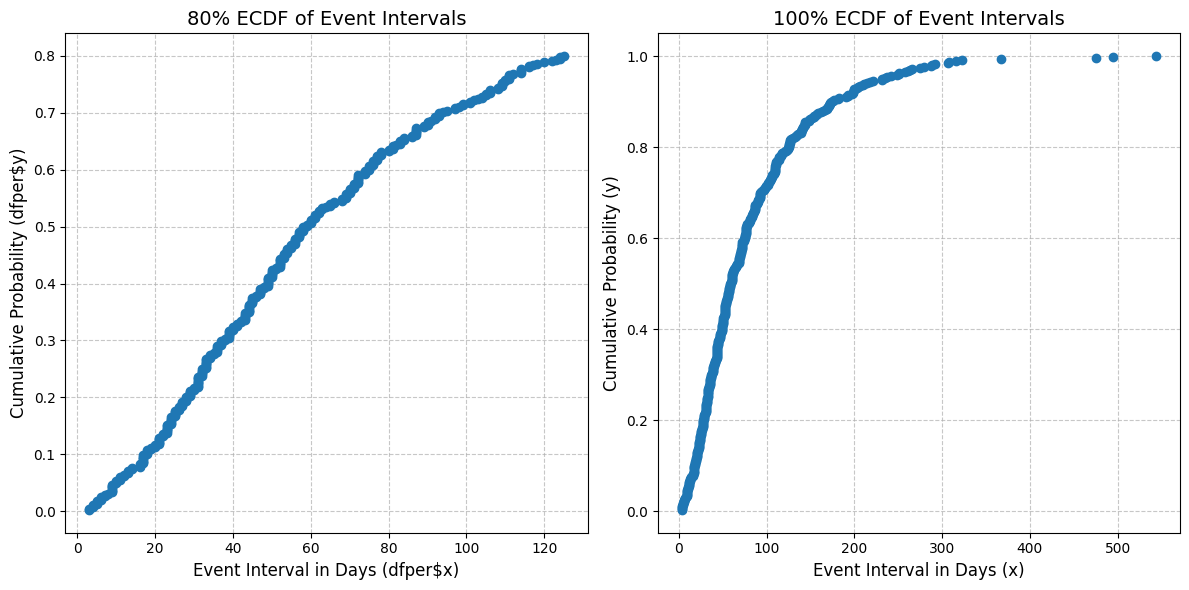

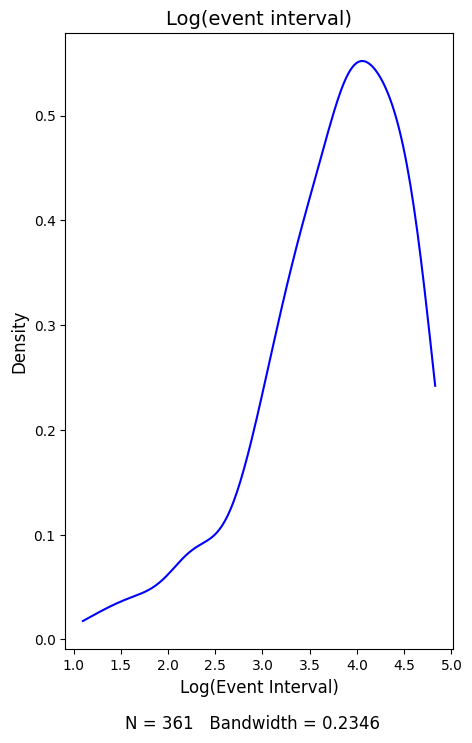

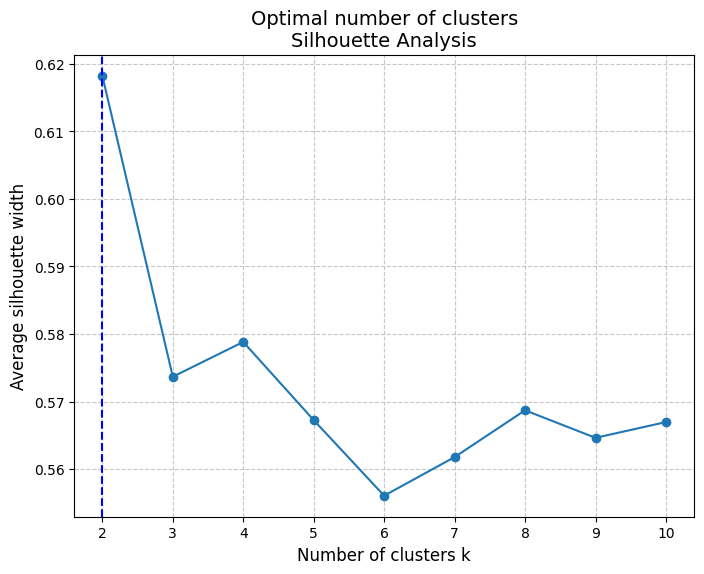

Optimal number of clusters for ATC code medA: 2


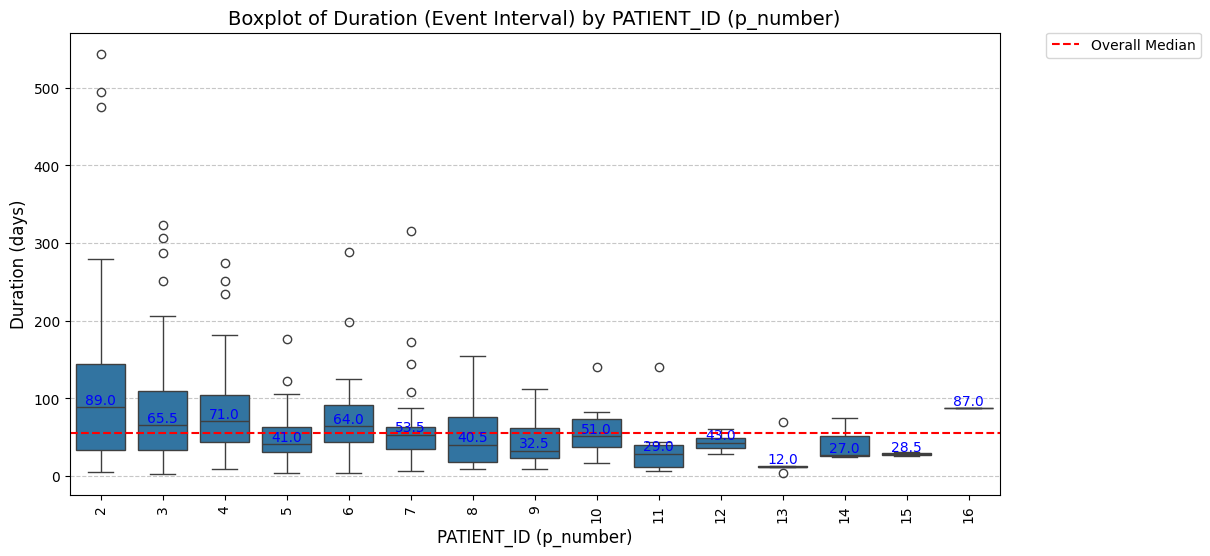

ATC code medB - Total events: 431, 80% events: 344, ni: 78


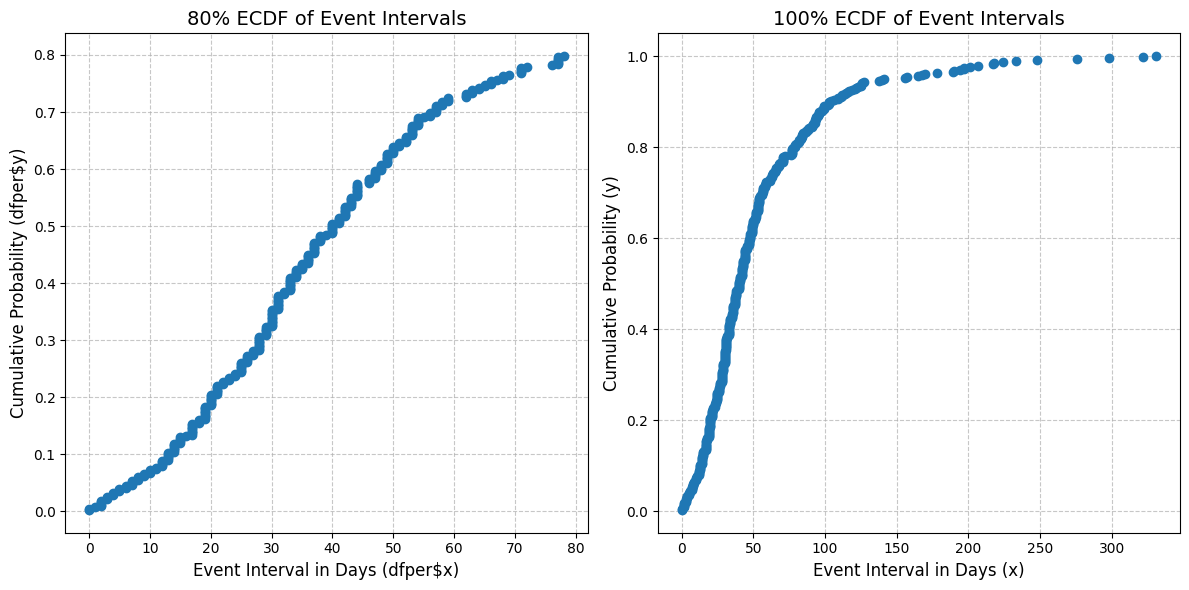

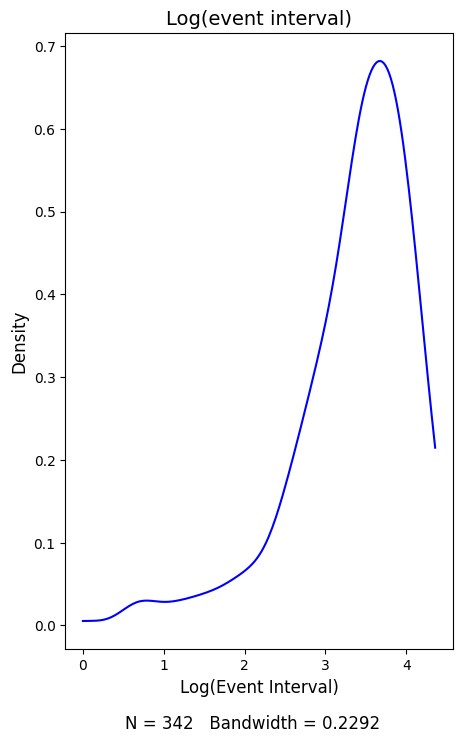

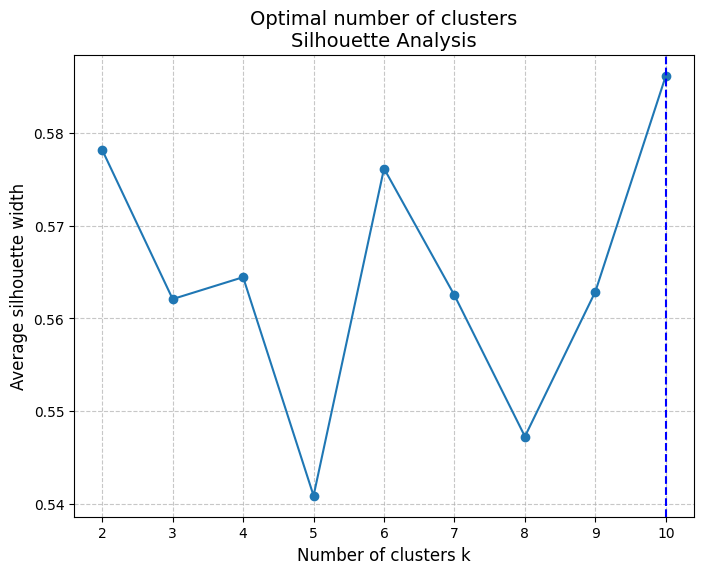

Optimal number of clusters for ATC code medB: 10


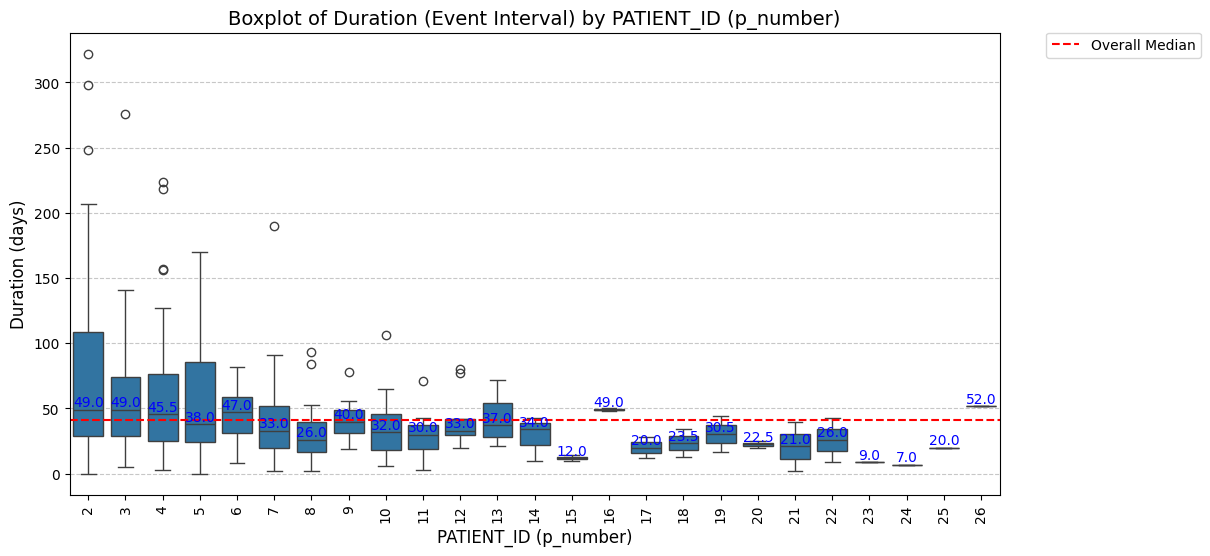

In [36]:
med_events_df = pd.read_csv('../data/tidy_dataset.csv', parse_dates=['eksd'])
# Rename columns to match code implementation
med_events_df.rename(columns={'eksd': 'DATE', 'perday': 'PERDAY', 'pnr': 'PATIENT_ID', 'dur_original': 'DURATION'}, inplace=True)
print("Dataset columns:", med_events_df.columns.tolist())

medA_df, medA_clusters = process_medications('medA')
medB_df, medB_clusters = process_medications('medB')